# Применение нейронных сетей для временного ряда

## GRU


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
def smape(A, F):
    return 100*np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# получение среза данных на lookback назад
def getdata(data_x, data_y, lookback):
    X, Y = [], []
    for i in range(len(data) - lookback + 1 - start_shift):
        X.append(data_x[i:i+lookback])
        Y.append(data_y[i+lookback-1])
    return np.array(X), np.array(Y).reshape(-1, 1)

In [3]:
df = pd.read_csv("https://video.ittensive.com/time-series/ittensive.time.series.04.csv", encoding="windows-1251",
                   delimiter=";", decimal=",", header=0) #, names=["Дата", "Объем"])
df = df.reset_index().drop(labels="index", axis=1)
df

,Дата,Открытие,Макс,Мин.,Закрытие
0,03.01.2020,255.99,258.19,253.70,255.00
1,06.01.2020,254.75,254.84,251.40,253.90
2,08.01.2020,253.57,259.15,253.03,259.15
3,09.01.2020,259.40,261.76,257.01,257.99
4,10.01.2020,257.86,259.25,256.88,258.19
...,...,...,...,...,...
627,27.12.2021,294.76,296.00,293.37,295.59
628,28.12.2021,295.84,297.55,294.18,294.98
629,29.12.2021,295.05,295.55,291.33,293.37
630,30.12.2021,293.60,294.89,291.52,293.39


In [4]:
df.columns = list(map(lambda x: x.lower(),(['Дата','Открытие','Макс','Мин','цена'])))
print (df.head())

         дата  открытие    макс     мин    цена
0  03.01.2020    255.99  258.19  253.70  255.00
1  06.01.2020    254.75  254.84  251.40  253.90
2  08.01.2020    253.57  259.15  253.03  259.15
3  09.01.2020    259.40  261.76  257.01  257.99
4  10.01.2020    257.86  259.25  256.88  258.19


In [27]:
data=df.copy()
# data = data.reset_index().drop(labels="index", axis=1)[::-1]
data["дата"] = pd.to_datetime(data["дата"])
data["день"] = data["дата"].dt.day
data["wd"] = data["дата"].dt.weekday
start_shift = 5
for i in range(1, start_shift+1):
    data["цена" + str(i)] = data["цена"].shift(i)
data.head()

,дата,открытие,макс,мин,цена,день,wd,цена1,цена2,цена3,цена4,цена5
0,2020-03-01,255.99,258.19,253.70,255.00,1,6,NaN,NaN,NaN,NaN,NaN
1,2020-06-01,254.75,254.84,251.40,253.90,1,0,255.00,NaN,NaN,NaN,NaN
2,2020-08-01,253.57,259.15,253.03,259.15,1,5,253.90,255.00,NaN,NaN,NaN
3,2020-09-01,259.40,261.76,257.01,257.99,1,1,259.15,253.90,255.0,NaN,NaN
4,2020-10-01,257.86,259.25,256.88,258.19,1,3,257.99,259.15,253.9,255.0,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632 entries, 631 to 0
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   дата      632 non-null    datetime64[ns]
 1   открытие  632 non-null    float64       
 2   макс      632 non-null    float64       
 3   мин       632 non-null    float64       
 4   цена      632 non-null    float64       
 5   день      632 non-null    int64         
 6   wd        632 non-null    int64         
 7   цена1     631 non-null    float64       
 8   цена2     630 non-null    float64       
 9   цена3     629 non-null    float64       
 10  цена4     628 non-null    float64       
 11  цена5     627 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 59.4 KB


Отнормируем данные и подготовим массивы

In [28]:
x_columns = ["цена1", "цена2", "цена3", "цена4", "цена5", "wd", "день"]
y_columns = ["цена"]
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_scaled = scaler_x.fit_transform(data[x_columns][start_shift:])
y_scaled = scaler_y.fit_transform(data[y_columns][start_shift:])

In [29]:
lookback = 10
x, y = getdata(x_scaled, y_scaled, lookback)
print(x.shape, y.shape)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2])
print(x.shape)

(618, 10, 7) (618, 1)
(618, 10, 7)


## Обучение модели GRU

In [30]:
batch_size=1
model = Sequential()
model.add(GRU(10, stateful=True, batch_input_shape=(batch_size, x.shape[1], x.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (1, 10)                   570       
                                                                 
 dense_2 (Dense)             (1, 1)                    11        
                                                                 
Total params: 581
Trainable params: 581
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(x[:-7], y[:-7], epochs=150, batch_size=batch_size)

Epoch 1/150
611/611 [==============================] - 4s 3ms/step - loss: 0.2168
Epoch 2/150
611/611 [==============================] - 3s 4ms/step - loss: 0.0236
Epoch 3/150
611/611 [==============================] - 3s 5ms/step - loss: 0.0162
Epoch 4/150
611/611 [==============================] - 2s 4ms/step - loss: 0.0130
Epoch 5/150
611/611 [==============================] - 2s 4ms/step - loss: 0.0126
Epoch 6/150
611/611 [==============================] - 2s 4ms/step - loss: 0.0110
Epoch 7/150
611/611 [==============================] - 2s 4ms/step - loss: 0.0114
Epoch 8/150
611/611 [==============================] - 3s 5ms/step - loss: 0.0108
Epoch 9/150
611/611 [==============================] - 2s 3ms/step - loss: 0.0108
Epoch 10/150
611/611 [==============================] - 2s 3ms/step - loss: 0.0106
Epoch 11/150
611/611 [==============================] - 2s 4ms/step - loss: 0.0103
Epoch 12/150
611/611 [==============================] - 2s 3ms/step - loss: 0.0098
Epoch 13/150


## Визуализация результата

In [32]:
y_test = scaler_y.inverse_transform(y[-120:])
forecast = scaler_y.inverse_transform(model.predict(x[-120:], batch_size=batch_size))

120/120 [==============================] - 1s 2ms/step


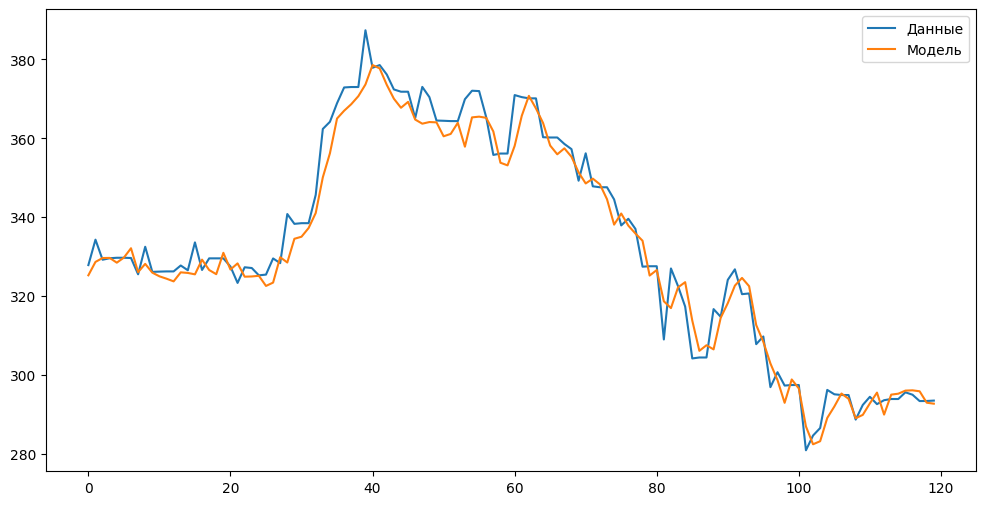

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(y_test)
plt.plot(forecast)
plt.legend(labels=["Данные", "Модель"])
plt.show()

Оценим ошибку

In [34]:
GRU_smape = smape(y_test[-7:], forecast[-7:])
print ("Ошибка модели:", GRU_smape)

Ошибка модели: 2.61644892825374


-----------
Прогноз

In [56]:
x_22 = x[-2:]
predictGru = scaler_y.inverse_transform(model.predict(x_22, batch_size=batch_size))
print(f'Предсказание GRU: {predictGru.mean()}')


2/2 [==============================] - 0s 7ms/step
Предсказание GRU: 292.82220458984375


## Обучение модели BiLSTM

In [57]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

In [58]:
batch_size=1
model_2 = Sequential()
model_2.add(Bidirectional(LSTM(10, stateful=True, batch_input_shape=(batch_size, x.shape[1], x.shape[2]))))
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error',optimizer='adam')
model_2.build(input_shape=(batch_size, x.shape[1], x.shape[2]))
model_2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (1, 20)                  1440      
 l)                                                              
                                                                 
 dense_3 (Dense)             (1, 1)                    21        
                                                                 
Total params: 1,461
Trainable params: 1,461
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_2.fit(x[:-7], y[:-7], epochs=100, batch_size=batch_size)

Epoch 1/100
611/611 [==============================] - 7s 6ms/step - loss: 0.0880
Epoch 2/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0375
Epoch 3/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0294
Epoch 4/100
611/611 [==============================] - 4s 7ms/step - loss: 0.0243
Epoch 5/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0215
Epoch 6/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0179
Epoch 7/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0172
Epoch 8/100
611/611 [==============================] - 4s 7ms/step - loss: 0.0148
Epoch 9/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0132
Epoch 10/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0126
Epoch 11/100
611/611 [==============================] - 3s 5ms/step - loss: 0.0121
Epoch 12/100
611/611 [==============================] - 5s 8ms/step - loss: 0.0112
Epoch 13/100


In [60]:
y_test = scaler_y.inverse_transform(y[-120:])
forecast = scaler_y.inverse_transform(model_2.predict(x[-120:], batch_size=batch_size))

120/120 [==============================] - 1s 2ms/step


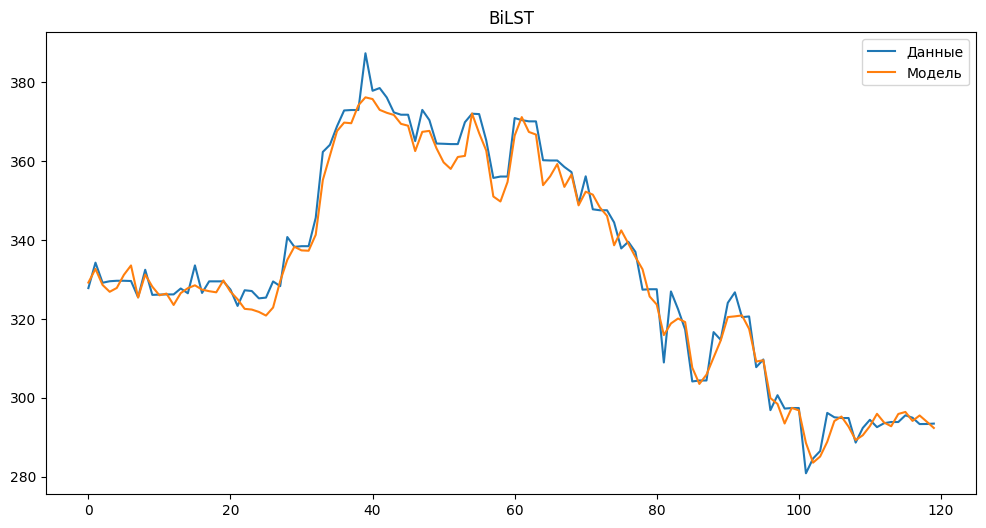

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(y_test)
plt.plot(forecast)
plt.legend(labels=["Данные", "Модель"])
plt.title('BiLST')
plt.show()

Оценим ошибку

In [62]:
Bil_smape = smape(y_test[-7:], forecast[-7:])
print ("Ошибка модели:", Bil_smape)

Ошибка модели: 2.9437701987564235


In [63]:
x_22 = x[-2:]
predictBil = scaler_y.inverse_transform(model_2.predict(x_22, batch_size=batch_size))
print(f'Предсказание BiLSTM: {predictBil.mean()}')


2/2 [==============================] - 0s 12ms/step
Предсказание BiLSTM: 292.721923828125
